In this vignette I will demonstrate how to model annual TROPOMI SIF using a 
set of climate variables from GRIDMET and geographic variables (elevation, 
mean annual precipitation, tree canopy cover, and ecoregion) as predictors 
within a linear mixed-effects (LME) model.

First, we will load the necessary packages to run the code

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Author: Lewis Kunik - University of Utah
# Contact: lewis.kunik@utah.edu
#

#%%
#########################################
# Load packages
#########################################

# File system packages
import os  # operating system library
import sys
import glob
from pathlib import Path
import copy

# numerical/data management packages
import numpy as np
import xarray as xr 
import pandas as pd

# shapefile/geospatial packages
import geopandas as gpd
from shapely.geometry import mapping
from shapely.geometry import Point

# Stats packages
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# time and date packages
import time
from datetime import datetime as dt  # date time library
from datetime import timedelta

# Standard plotting packages
from matplotlib import pyplot as plt  # primary plotting module
from matplotlib.ticker import FuncFormatter as FFmt  # need this for formatting plot ticks
import matplotlib.colors as mcolors

# Geospatial plotting packages
import cartopy.crs as ccrs  # cartopy is the best spatial plotting library i know
from cartopy.io import img_tiles  # cartopy's implementation of webtiles
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature



Define any global filepaths and variables that will be needed throughout the script

In [3]:

#########################################
# Define Global Filepaths
#########################################

dat_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/'
dat_dir_precip = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/data/TOT_WY_Precip'
plot_basedir = '/uufs/chpc.utah.edu/common/home/lin-group19/ltk/SIF/SIF_IAV/plots/'
EPA_ecoregion_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/EPA/ecoregions/'
NLCD_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/NLCD/'
elev_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/SRTM/WUS/'
MAP_dir = '/uufs/chpc.utah.edu/common/home/lin-group23/ltk/GRIDMET/Precip/05d_1980-2010_mean/'

TCC_file = os.path.join(NLCD_dir, 'TreeCover/2019/NLCD_TCC_05d_WUS_2019.nc')
EPA_ecoregion_L3_file = os.path.join(EPA_ecoregion_dir, 'L3', 'WUS_cec_eco_l3.shp')
elev_file = os.path.join(elev_dir, 'SRTM_DEM_05d_WUS.nc')
MAP_file = os.path.join(MAP_dir, 'GRIDMET_TotalWYPrecip_WUS_1980-2010_mean.nc')

########################################
# Define Global Variables and constants
#########################################

# Define the averaging window definition for "annual" values
timing_label = 'FULL_YEAR' # options: "FULL_YEAR", "TOP_QUARTILE", "POST_PEAK_LAI", "PRE_PEAK_LAI"
dat_dir = os.path.join(dat_basedir, timing_label)  # directory where data files are stored, based on timing_label
analysis_years = range(2018, 2024)

## Define paths to data files
TROPOMI_SIF_file = glob.glob(f'{dat_dir}/TROPOMI_SIF*.nc')[0]

GRIDMET_Tmax_file = glob.glob(f'{dat_dir}/GRIDMET_Tmax*.nc')[0]
GRIDMET_Tmin_file = glob.glob(f'{dat_dir}/GRIDMET_Tmin*.nc')[0]
GRIDMET_VPD_file = glob.glob(f'{dat_dir}/GRIDMET_VPD*.nc')[0]
GRIDMET_Precip_file = glob.glob(f'{dat_dir_precip}/GRIDMET_TotWYPrecip*.nc')[0]
TerraClimate_SoilM_file = glob.glob(f'{dat_dir}/TerraClimate_SoilM*.nc')[0]

# Remote sensing vegetation indices files
# MODIS_NDVI_file = glob.glob(f'{dat_dir}/MODIS_MOD13A2_NDVI*.nc')[0]
# MODIS_NDMI_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NDMI*.nc')[0]
# MODIS_NIRv_file = glob.glob(f'{dat_dir}/MODIS_MCD43A4_NIRv*.nc')[0]
# MODIS_LAI_file = glob.glob(f'{dat_dir}/MODIS_MOD15A2H_LAI*.nc')[0]
# MODIS_LST_file = glob.glob(f'{dat_dir}/MODIS_MYD21A2_LST*.nc')[0]

# Drought index files
# GRIDMET_PDSI_file = glob.glob(f'{dat_dir}/GRIDMET_PDSI*.nc')[0]
# TerraClimate_CWD_file = glob.glob(f'{dat_dir}/TerraClimate_CWD*.nc')[0]
# nClimGrid_SPEI_01_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_01*.nc')[0]
# nClimGrid_SPEI_02_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_02*.nc')[0]
# nClimGrid_SPEI_03_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_03*.nc')[0]
# nClimGrid_SPEI_06_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_06*.nc')[0]
# nClimGrid_SPEI_09_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_09*.nc')[0]
# nClimGrid_SPEI_12_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_12*.nc')[0]
# nClimGrid_SPEI_24_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_24*.nc')[0]
# nClimGrid_SPEI_36_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_36*.nc')[0]
# nClimGrid_SPEI_48_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_48*.nc')[0]
# nClimGrid_SPEI_60_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_60*.nc')[0]
# nClimGrid_SPEI_72_file = glob.glob(f'{dat_dir}/nClimGrid_SPEI_72*.nc')[0]

# # Climate Standardized anomaly files
# GRIDMET_Tmax_SA_file = glob.glob(f'{dat_dir}/GRIDMET_Tmax*std_anomaly*.nc')[0]
# GRIDMET_Tmin_SA_file = glob.glob(f'{dat_dir}/GRIDMET_Tmin*std_anomaly*.nc')[0]
# GRIDMET_VPD_SA_file = glob.glob(f'{dat_dir}/GRIDMET_VPD*std_anomaly*.nc')[0]
# GRIDMET_Precip_SA_file = glob.glob(f'{dat_dir_precip}/GRIDMET_TotWYPrecip*std_anomaly*.nc')[0]
# TerraClimate_SoilM_SA_file = glob.glob(f'{dat_dir}/TerraClimate_SoilM*std_anomaly*.nc')[0]

#########################################
# Set plotting parameters
#########################################

plt.rcParams.update({
   'axes.labelsize': 16,
   'axes.titlesize': 16,
   'xtick.labelsize': 16,
   'ytick.labelsize': 15,
   'legend.fontsize': 13,
})

# use Google Satellite imagery as basemap
tiler = img_tiles.GoogleTiles(style='satellite')
crs = tiler.crs # set crs of map tiler
alpha = 0.8  # transparency 0-1
transform = ccrs.PlateCarree()  # transform specifies the crs that the data is in

tiler_zoom = 7  # define a zoom level of detail
extent = [-125.3, -102.7, 29.7, 50.3]  # [minx, maxx, miny, maxy], bounds for map

### Load state boundaries
fn = shpreader.natural_earth(
   resolution='10m', category='cultural', 
   name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
states = [x for x in reader.records() if x.attributes["admin"] == "United States of America"] # get all states in US
states_geom = cfeature.ShapelyFeature([x.geometry for x in states], ccrs.PlateCarree())

# matplotlib map plotting functions
def z_axis_formatter(x, pos, deci=2):
   '''Format ticks to format with deci number of decimals'''

   return f'{x:.{deci}f}'



Define any functions that will be needed throughout the script

In [4]:
#########################################
# Define Global Functions
#########################################


def xarray_to_long_df(da_dict, response_var_name):
    """
    Convert dictionary of xarray DataArrays to long format DataFrame
    suitable for mixed effects modeling
    """
    # Start with response variable - only keep essential coordinates
    response_da = da_dict[response_var_name]
    df = response_da.to_dataframe(name=response_var_name).reset_index()
    
    # Keep only the columns we need for merging and analysis
    essential_cols = ['x', 'y', response_var_name]
    if 'year' in df.columns:
        essential_cols.append('year')
    
    df = df[essential_cols].dropna(subset=[response_var_name])
    
    # Add explanatory variables one by one
    for var_name, da in da_dict.items():
        if var_name != response_var_name:
            # Convert to dataframe and keep only essential columns
            var_df = da.to_dataframe(name=var_name).reset_index()
            
            # Keep only coordinates and the variable of interest
            var_essential_cols = ['x', 'y', var_name]
            if 'year' in var_df.columns:
                var_essential_cols.append('year')
            
            var_df = var_df[var_essential_cols].dropna(subset=[var_name])
            
            # Handle time-invariant variables (no year dimension)
            if 'year' not in var_df.columns and 'year' in df.columns:
                # Replicate time-invariant data for each year
                years = df['year'].unique()
                var_df_expanded = []
                for year in years:
                    temp_df = var_df.copy()
                    temp_df['year'] = year
                    var_df_expanded.append(temp_df)
                var_df = pd.concat(var_df_expanded, ignore_index=True)
            
            # Determine merge columns
            merge_cols = ['x', 'y']
            if 'year' in var_df.columns:
                merge_cols.append('year')
                
            # Merge with main dataframe
            df = df.merge(var_df, on=merge_cols, how='inner')
    
    return df


# -----------------------------------------------------------------------
# Function from Dave to calculate fit metrics from model predictions
# -----------------------------------------------------------------------
def calc_fit_metrics(y_true, y_pred, popt=None, pcov=None, n_params=None):
    """
    Calculate fit metrics for model predictions.
    Parameters:
        y_true: observed values (1D array)
        y_pred: predicted values (1D array, same length as y_true)
        popt: fitted parameters (1D array, optional, for t-stats/p-values)
        pcov: covariance matrix from fit (2D array, optional, for perr/t-stats/p-values)
        n_params: int, optional, number of fitted parameters (for AIC/AICc if popt is not provided)
    Returns:
        metrics: dict with rsq, rmse, mae, perr, t_stats, p_values, f_stat, f_p_value, AIC, AIC_c
    """
    from scipy.stats import t, f
    import numpy as np

    mask = ~np.isnan(y_true) & ~np.isnan(y_pred) # omit any nans
    y_true = y_true[mask]              
    y_pred = y_pred[mask]
    n = len(y_true)                   # length
    residuals = y_true - y_pred       # residuals
    rss = np.sum(residuals ** 2)      # residual sum of squares
    tss = np.sum((y_true - np.mean(y_true)) ** 2)  # total sum of squares
    rsq = 1 - (rss / tss) if tss > 0 else np.nan   # R-squared
    rmse = np.sqrt(rss / n) if n > 0 else np.nan   # root mean square error
    mae = np.mean(np.abs(residuals)) if n > 0 else np.nan  # mean absolute error

    # Defaults for parameter statistics
    perr = t_stats = p_values = f_stat = f_p_value = np.nan

    # Determine number of parameters for AIC/AICc
    if popt is not None:
        k = len(popt)
    elif n_params is not None:
        k = n_params
    else:
        k = 1  # fallback

    # Parameter statistics if possible
    if popt is not None and pcov is not None and np.all(np.isfinite(pcov)):
        try:
            perr = np.sqrt(np.diag(pcov))
            t_stats = popt / perr
            dof = n - len(popt)
            p_values = [2 * (1 - t.cdf(np.abs(t_stat), dof)) for t_stat in t_stats]
            msr = (tss - rss) / (len(popt) - 1) if len(popt) > 1 else np.nan
            mse = rss / dof if dof > 0 else np.nan
            f_stat = msr / mse if mse != 0 else np.nan
            f_p_value = 1 - f.cdf(f_stat, len(popt) - 1, dof) if (len(popt) > 1 and dof > 0) else np.nan
        except Exception:
            perr = t_stats = p_values = f_stat = f_p_value = np.nan

    # AIC and AICc
    log_L = -(n / 2) * np.log(rss / n) if n > 0 and rss > 0 else np.nan
    AIC = 2 * k - 2 * log_L if log_L is not np.nan else np.nan
    AIC_c = AIC + (2 * k * (k + 1)) / (n - k - 1) if (AIC is not np.nan and n > k + 1) else np.nan

    metrics = {
        "rsq": rsq,
        "rmse": rmse,
        "mae": mae,
        "perr": perr,
        "t_stats": t_stats,
        "p_values": p_values,
        "f_stat": f_stat,
        "f_p_value": f_p_value,
        "log_L": log_L,
        "AIC": AIC,
        "AIC_c": AIC_c
    }
    return metrics


def calculate_mixed_model_r2(result, df):
    """
    Calculate marginal and conditional R² for mixed effects model
    
    Based on Nakagawa & Schielzeth (2013)
    """
    # Get predictions
    fixed_pred = result.predict(df) # Fixed effects only
    full_pred = result.fittedvalues  # Fixed + random effects
    
    # Observed values
    y_obs = df['SIF'].values
    y_mean = np.mean(y_obs)
    
    # Total variance
    var_total = np.var(y_obs)
    
    # Variance of fixed effects predictions
    var_fixed = np.var(fixed_pred)
    
    # Variance of residuals
    var_resid = result.scale  # residual variance from model
    
    # Marginal R² (fixed effects only)
    r2_marginal = var_fixed / var_total
    
    # For conditional R², we need random effects variance
    # Extract random effects variance (between pixels)
    var_random = float(result.cov_re.iloc[0, 0])  # variance of random intercepts
    
    # Conditional R² (fixed + random effects)
    r2_conditional = (var_fixed + var_random) / var_total
    
    return r2_marginal, r2_conditional


# -----------------------------------------------------------------------
# Function to calculate empirical semivariogram
# -----------------------------------------------------------------------
def calculate_semivariogram(residuals, distances, n_bins=20, max_distance=None):
    """
    Calculate empirical semivariogram from residuals and distances
    
    Parameters:
    -----------
    residuals : array
        Residual values for each location
    distances : array
        Pairwise distances (condensed form from pdist)
    n_bins : int
        Number of distance bins
    max_distance : float
        Maximum distance to consider (if None, uses max distance)
    
    Returns:
    --------
    bin_centers : array
        Center of each distance bin
    semivariance : array
        Semivariance for each bin
    counts : array
        Number of pairs in each bin
    """
    
    # Get pairwise differences in residuals
    n = len(residuals)
    resid_diff = []
    
    for i in range(n):
        for j in range(i+1, n):
            resid_diff.append((residuals[i] - residuals[j])**2)
    
    resid_diff = np.array(resid_diff)
    
    # Set max distance if not provided
    if max_distance is None:
        max_distance = distances.max()
    
    # Create distance bins
    bins = np.linspace(0, max_distance, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Calculate semivariance for each bin
    semivariance = np.zeros(n_bins)
    counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        # Find pairs within this distance bin
        mask = (distances >= bins[i]) & (distances < bins[i+1])
        
        if mask.sum() > 0:
            # Semivariance = 0.5 * mean of squared differences
            semivariance[i] = 0.5 * resid_diff[mask].mean()
            counts[i] = mask.sum()
    
    return bin_centers, semivariance, counts


Load all the relevant pre-aggregated annual files and geographic datasets, including:
    -TROPOMI SIF
    -GRIDMET climate reanalysis data
    -NASA SRTM elevation data
    -National Land Cover Database (NLCD) Tree Canopy Cover data
    -GRIDMET historical avg mean annual precipitation (1980-2010)
Note that all datasets have been spatially regridded to 0.05° grid resolution

In [ ]:
# -----------------------------------------------------------------------
# Function to load xarray data and set CRS
# -----------------------------------------------------------------------
def load_xr(dat_xr_file, varname = None):
    if varname is not None:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)[varname]
    else:
        dat_xr = xr.open_dataset(dat_xr_file, decode_coords='all').sortby(['x', 'y'], ascending = True)
    dat_xr.rio.write_crs(4326, inplace=True)
    return dat_xr
    
###### Load all the files as xarray dataarrays
TROPOMI_SIF_xr = load_xr(TROPOMI_SIF_file, 'sifdc') # TROPOMI SIF

GRIDMET_Tmax_xr = load_xr(GRIDMET_Tmax_file, 'air_temperature') # GRIDMET Tmax
GRIDMET_Tmin_xr = load_xr(GRIDMET_Tmin_file, 'air_temperature') # GRIDMET Tmin
GRIDMET_VPD_xr = load_xr(GRIDMET_VPD_file, 'mean_vapor_pressure_deficit') # GRIDMET VPD
GRIDMET_Precip_xr = load_xr(GRIDMET_Precip_file, 'precipitation_amount') # GRIDMET Precipitation
TerraClimate_SoilM_xr = load_xr(TerraClimate_SoilM_file, 'soil') # TerraClimate Soil Moisture

# Remote sensing vegetation indices files
# MODIS_NDVI_xr = load_xr(MODIS_NDVI_file, 'NDVI') # MODIS NDVI
# MODIS_NDMI_xr = load_xr(MODIS_NDMI_file, 'NDMI') # MODIS NDMI
# MODIS_NIRv_xr = load_xr(MODIS_NIRv_file, 'NIRv') # MODIS NIRv
# MODIS_LAI_xr = load_xr(MODIS_LAI_file, 'LAI') # MODIS LAI
# MODIS_LST_xr = load_xr(MODIS_LST_file, 'LST_Day') # MODIS LST

# Drought index files
# GRIDMET_PDSI_xr = load_xr(GRIDMET_PDSI_file, 'pdsi') # GRIDMET PDSI
# TerraClimate_CWD_xr = load_xr(TerraClimate_CWD_file, 'def') # TerraClimate CWD
# nClimGrid_SPEI_01_xr = load_xr(nClimGrid_SPEI_01_file, 'SPEI_pearson') # nClimGrid SPEI 01
# nClimGrid_SPEI_02_xr = load_xr(nClimGrid_SPEI_02_file, 'SPEI_pearson') # nClimGrid SPEI 02
# nClimGrid_SPEI_03_xr = load_xr(nClimGrid_SPEI_03_file, 'SPEI_pearson') # nClimGrid SPEI 03
# nClimGrid_SPEI_06_xr = load_xr(nClimGrid_SPEI_06_file, 'SPEI_pearson') # nClimGrid SPEI 06
# nClimGrid_SPEI_09_xr = load_xr(nClimGrid_SPEI_09_file, 'SPEI_pearson') # nClimGrid SPEI 09
# nClimGrid_SPEI_12_xr = load_xr(nClimGrid_SPEI_12_file, 'SPEI_pearson') # nClimGrid SPEI 12
# nClimGrid_SPEI_24_xr = load_xr(nClimGrid_SPEI_24_file, 'SPEI_pearson') # nClimGrid SPEI 24
# nClimGrid_SPEI_36_xr = load_xr(nClimGrid_SPEI_36_file, 'SPEI_pearson') # nClimGrid SPEI 36
# nClimGrid_SPEI_48_xr = load_xr(nClimGrid_SPEI_48_file, 'SPEI_pearson') # nClimGrid SPEI 48
# nClimGrid_SPEI_60_xr = load_xr(nClimGrid_SPEI_60_file, 'SPEI_pearson') # nClimGrid SPEI 60
# nClimGrid_SPEI_72_xr = load_xr(nClimGrid_SPEI_72_file, 'SPEI_pearson') # nClimGrid SPEI 72  

# Climate Standardized anomaly files
# GRIDMET_Tmax_SA_xr = load_xr(GRIDMET_Tmax_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmax Standardized Anomaly
# GRIDMET_Tmin_SA_xr = load_xr(GRIDMET_Tmin_SA_file, '__xarray_dataarray_variable__') # GRIDMET Tmin Standardized Anomaly
# GRIDMET_VPD_SA_xr = load_xr(GRIDMET_VPD_SA_file, '__xarray_dataarray_variable__') # GRIDMET VPD Standardized Anomaly
# GRIDMET_Precip_SA_xr = load_xr(GRIDMET_Precip_SA_file, '__xarray_dataarray_variable__') # GRIDMET Precipitation Standardized Anomaly
# TerraClimate_SoilM_SA_xr = load_xr(TerraClimate_SoilM_SA_file, '__xarray_dataarray_variable__') # TerraClimate Soil Moisture Standardized Anomaly



### Visualize the data

Let's plot some maps of the datasets just to understand their patterns

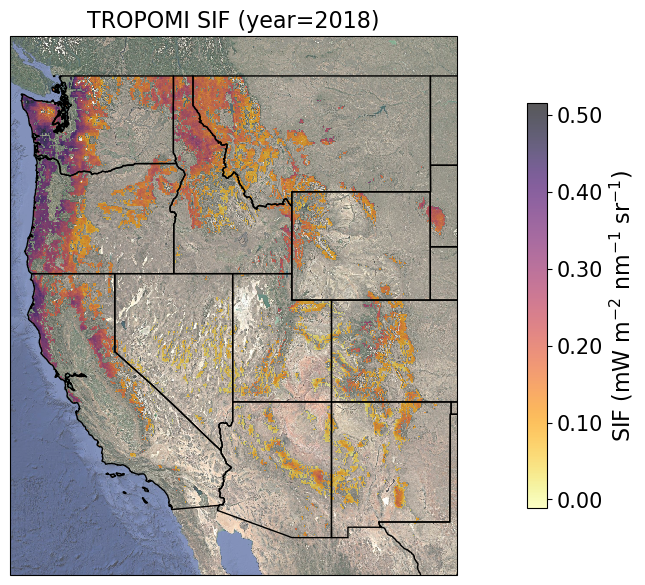

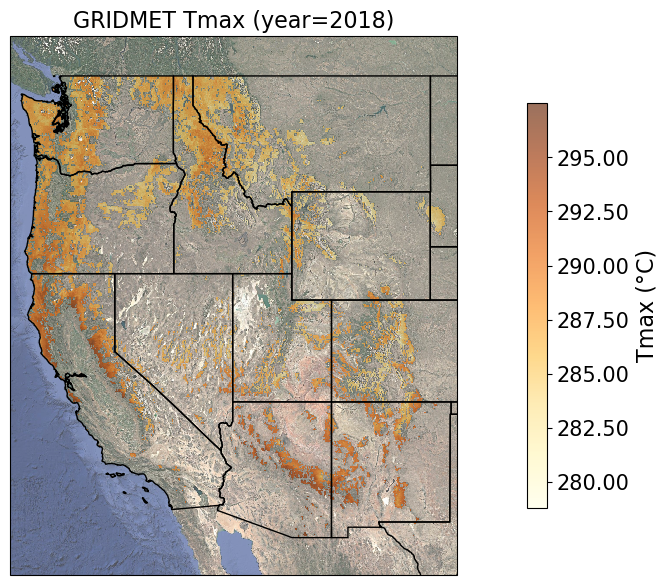

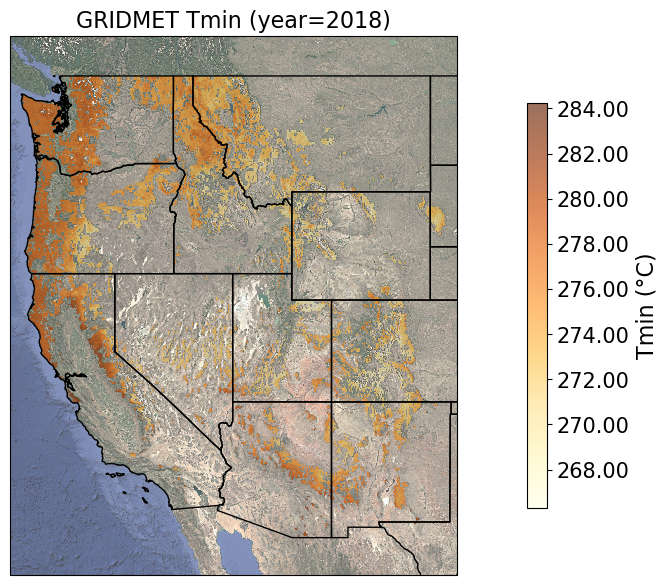

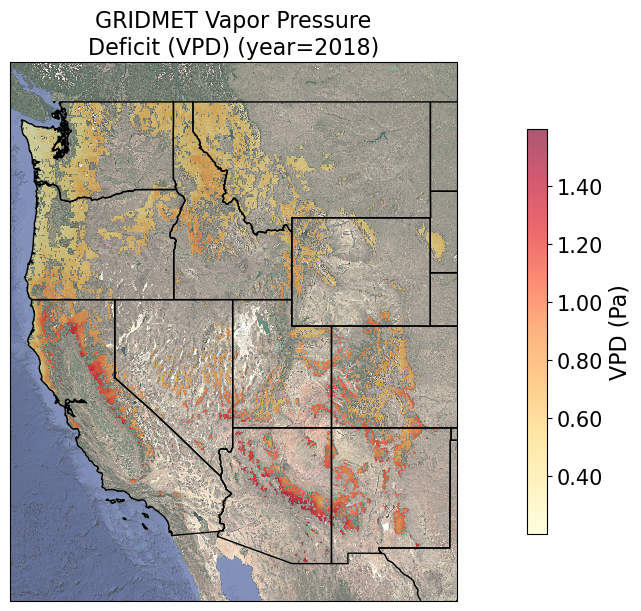

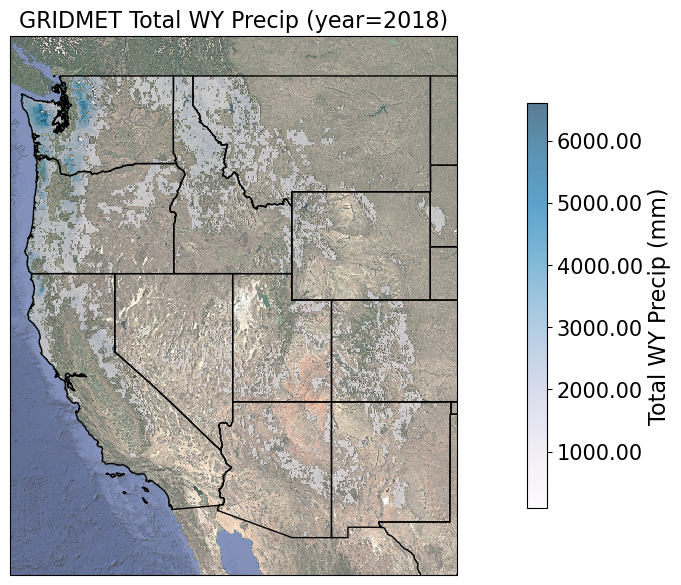

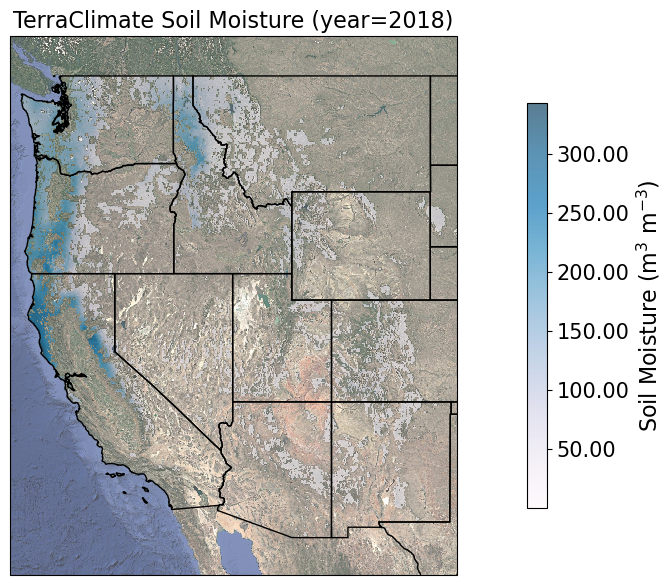

In [23]:
def plot_dataarray_map(dat_da, plotTitle, zax_label, plot_min=None, plot_max=None, cmap='inferno_r'):
    if plot_min is None:
        plot_min = np.nanmin(dat_da.values)
    if plot_max is None:
        plot_max = np.nanmax(dat_da.values)
    fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=(9, 7)) # establish the figure, axes
    # Set extent of map before adding base img
    ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
    ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.7) # Add base image

    # add state boundaries to the map
    ax.add_feature(states_geom, facecolor="none", edgecolor="black", linewidth=1)

    dat_da.plot(ax=ax, transform=transform, alpha=alpha, 
                    cmap=cmap, vmin = plot_min, vmax = plot_max,
                        cbar_kwargs={'orientation': 'vertical',
                                            'pad': 0.1,
                                            'label': zax_label,
                                            'shrink': 0.75,
                                            'format': FFmt(z_axis_formatter)})

    plt.title(plotTitle) # set axis title
    plt.show()


plot_dataarray_map(TROPOMI_SIF_xr.isel(year=0), 'TROPOMI SIF (year=2018)', 
    'SIF (mW m$^{-2}$ nm$^{-1}$ sr$^{-1}$)')

plot_dataarray_map(GRIDMET_Tmax_xr.isel(year=0), 'GRIDMET Tmax (year=2018)', 
    'Tmax (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_Tmin_xr.isel(year=0), 'GRIDMET Tmin (year=2018)', 
    'Tmin (°C)', cmap='YlOrBr')

plot_dataarray_map(GRIDMET_VPD_xr.isel(year=0), 'GRIDMET Vapor Pressure\nDeficit (VPD) (year=2018)', 
    'VPD (Pa)', cmap='YlOrRd')

plot_dataarray_map(GRIDMET_Precip_xr.isel(year=0), 'GRIDMET Total WY Precip (year=2018)', 
    'Total WY Precip (mm)', cmap='PuBu')

plot_dataarray_map(TerraClimate_SoilM_xr.isel(year=0), 'TerraClimate Soil Moisture (year=2018)', 
    'Soil Moisture (m$^3$ m$^{-3}$)', cmap='PuBu')






#### Now we will start formatting the data to use in our model


In [21]:

# Flatten response variable (SIF) to 1D array
sif_flat = TROPOMI_SIF_xr.stack(sample=TROPOMI_SIF_xr.dims).values
valid_idx = ~np.isnan(sif_flat) # Remove NaNs
sif_flat_valid = sif_flat[valid_idx]

# Create an array of the xarray variables to test as covariates
covariate_xr_arr = [GRIDMET_Tmax_xr, GRIDMET_Tmin_xr, GRIDMET_VPD_xr, GRIDMET_Precip_xr, TerraClimate_SoilM_xr]
covariate_names = ['Tmax', 'Tmin', 'VPD', 'Precip', 'SoilM']
static_vars = ['TCC', 'elevation', 'latitude']

# Stack the covariates into a 2D array (samples x features)
# First, flatten each covariate and combine into a DataFrame
covariate_data = []
for i, covariate_xr in enumerate(covariate_xr_arr):
    # Stack all dimensions and convert to a 1D array
    stacked = covariate_xr.stack(sample=covariate_xr.dims).values
    covariate_data.append(stacked)

# Create DataFrame with all covariates
covariate_df = pd.DataFrame(
    np.column_stack(covariate_data),
    columns=covariate_names
)

# Remove rows with any NaN values
covariate_df = covariate_df.dropna()


#### Checking for multi-collinearity in the predictors
Since we are comparing various gridded climate-related datasets, there is likely 
to be inherent correlated spatial and temporal structures in the datasets

#### Why is this important?
A consequence of multiple correlated predictor variables in a model is that they will skew the reported metrics in the model result because there is overlapping correlation between the predictors and the response variable.

#### How do we test for multi-collinearity?
One method to test for this is using a "variance inflation factor" (VIF) which tests how much the variance is inflated by the presence of a variable amongst its cohort of other predictors in the predictor set

You can see below that Daily Maximum Temperature (Tmax) and Daily Minimum Temperature (Tmin) have extraordinarily large VIF values - that is because these two datasets are highly correlated with one another. 

For context, a VIF of 5 or 10 often signifies the threshold above which multi-collinearity is assumed to be present in the predictor set.

There is also likely spatial autocorrelation that we haven't accounted for (yet) which would probably inflate the variance even further...
Based on this, we should assume that there is multi-collinearity present in the predictor set and proceed accordingly

In [22]:

# Calculate VIF for each covariate
vif_data = pd.DataFrame()
vif_data["Variable"] = covariate_names
vif_data["VIF"] = [variance_inflation_factor(covariate_df.values, i) 
                   for i in range(len(covariate_names))]

print(f"\nVariance Inflation Factors for covariates:")
print(vif_data)

### Variance inflation factors above 5-10 usually indicate multicollinearity


Variance Inflation Factors for covariates:
  Variable           VIF
0     Tmax  30047.405549
1     Tmin  29753.432526
2      VPD     18.426150
3   Precip      5.683624
4    SoilM      3.250939


## The Mixed-Effects Model
Within a Mixed-effects model, we can define the set of effects that we expect to be fixed (the "signal" we are estimating) and the effects that we expect to be random (the "noise" we want to charactarize and set aside). Here, we will try to estimate a fixed slope and a fixed intercept to charactarize the relationship between SIF and the climate predictor across the Western US. We will explicitly set the intercept of each unique pixel in the analysis (denoted as the "pixed_id" term in the dataframe below) as a random effect, allowing it to vary randomly without affecting the overall relationship across the Western US.  

The general formula for the mixed effect model is:

$$y_{i} = \beta_0 + \beta_1 x_{i} + u + \epsilon_{i}$$

where:
- $y_{i}$ is the response for observation $i$
- $\beta_0$ is the fixed intercept
- $\beta_1$ is the fixed effect coefficient
- $x_{i}$ is the predictor variable
- $u \sim N(0, \sigma_u^2)$ is the random effect
- $\epsilon_{i} \sim N(0, \sigma^2)$ is the residual error


#### Setp 1: The simplest model
Given that we identified correlated patterns in our predictors, We will model SIF using each predictor individually.
To start off, we won't include any other explanatory/predictor terms in the model.

##### Note:
When we set up each model, we standardize each of the predictors by their mean and standard deviation to essentially produce a z-score dataset which we actually use to model against SIF. So, the coefficients we get in the model result tell us how much change in SIF we would expect given a 1 standard deviation increase in the predictor variable. When the predictors are standardized in this way, we can compare the results across models with inputs of different magnitudes and units.



Modeling variable: Tmax


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: Tmin


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: VPD


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: Precip


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: SoilM


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


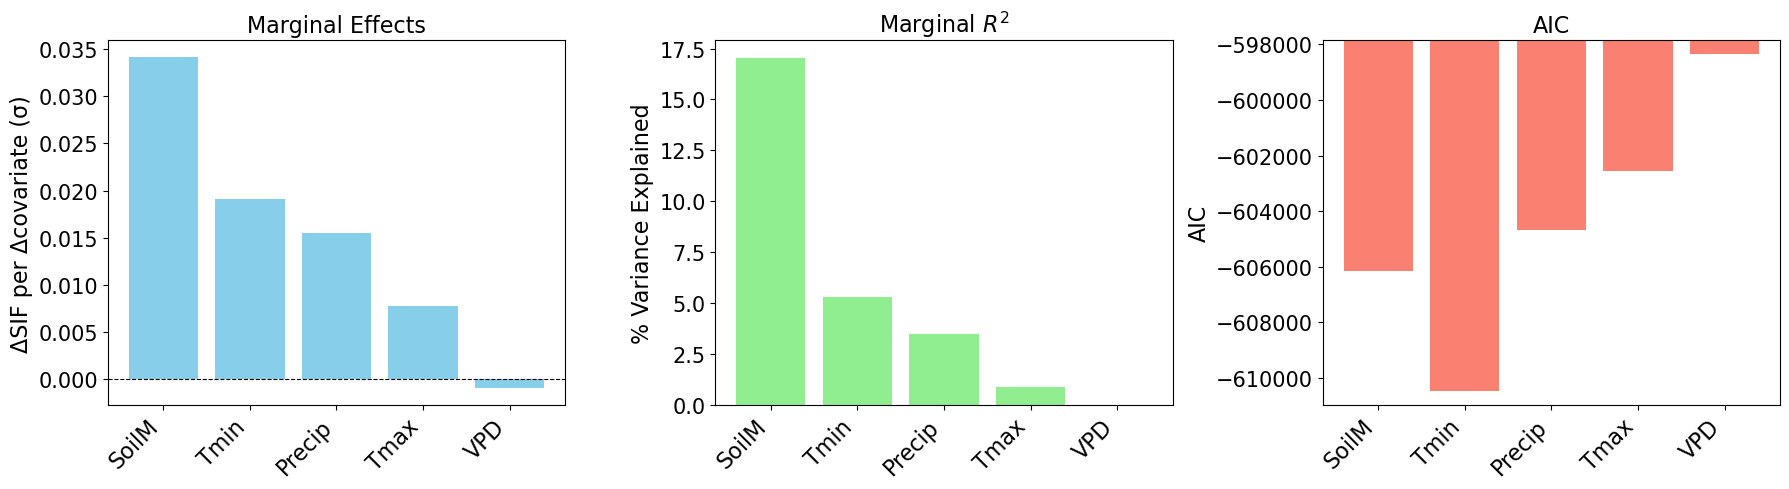

In [ ]:
# set up a blank dict to hold the model results for each covariate
covariate_results = {}

# Loop through each covariate and fit mixed effects model
for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):

    model_results = {}
    xr_data_dict = {
        'SIF': TROPOMI_SIF_xr,
        covariate_name: covariate_xr,
    }

    df_long = xarray_to_long_df(xr_data_dict, 'SIF')
    key_vars = ['SIF', covariate_name]

    # Add pixel_id, longitude, latitude
    df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
    df_long['longitude'] = df_long['x']
    df_long['latitude'] = df_long['y']

    # Clean up - remove rows with missing values in key variables
    df_model = df_long.dropna(subset=key_vars).copy()

    # Standardize predictors
    all_predictors = [covariate_name]
    df_standardized = df_model.copy()
    df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

    # Fit mixed effects model (random intercepts per pixel)
    formula = f'SIF ~ {covariate_name}'
    print(f'modeling formula: {formula}')
    try:
        model = smf.mixedlm(
            formula, data=df_standardized,
            groups=df_standardized["pixel_id"]
        )
        result = model.fit()
        model_results['full_result'] = result
        model_results['coeff'] = result.params[covariate_name]
    except Exception as e:
        print(f"Model fitting failed: {e}")

    # Calculate marginal and conditional R²
    r2_marginal, r2_conditional = calculate_mixed_model_r2(result, df_standardized)
    model_results['r2_marginal'] = r2_marginal
    model_results['r2_conditional'] = r2_conditional

    #### compute AIC and fit metrics
    # Get log-likelihood and number of parameters
    llf = result.llf  # log-likelihood
    nobs = result.nobs  # number of observations
    k = len(result.params) + 1  # +1 for variance component

    # Calculate AIC and BIC manually
    aic = -2 * llf + 2 * k
    bic = -2 * llf + k * np.log(nobs)
    model_results['AIC'] = aic
    model_results['BIC'] = bic

    # # Below is Dave's method
    # # predicted_values = result.predict(df_standardized)
    # predicted_values = result.fittedvalues
    # # Get fitted parameters and covariance matrix from the model result
    # popt = result.params.values
    # pcov = result.cov_params().values
    # n_params = len(popt) + 1 # +1 for variance component

    # fit_metrics = calc_fit_metrics(df_standardized['SIF'], predicted_values, popt=popt, pcov=pcov, n_params=n_params)

    covariate_results[covariate_name] = model_results

# Sort the 'coeff' for each covariate_name from highest to lowest
sorted_coeffs = sorted(
    ((name, res['coeff']) for name, res in covariate_results.items()),
    key=lambda x: x[1], reverse=True
)
# Sort the 'r2_marginal' for each covariate_name from highest to lowest
sorted_r2_marginal = sorted(
    ((name, res['r2_marginal']) for name, res in covariate_results.items()),
    key=lambda x: x[1], reverse=True
)
# Get the covariate order from sorted_r2_marginal
covariate_order = [name for name, _ in sorted_r2_marginal]

# Get values in this order
coeffs = [covariate_results[name]['coeff'] for name in covariate_order]
r2s = [covariate_results[name]['r2_marginal']*100 for name in covariate_order]
aics = [covariate_results[name]['AIC'] for name in covariate_order]

# AIC limits
aic_min = min(aics) - 500
aic_max = max(aics) + 500

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

# Coefficient bar plot
axes[0].bar(covariate_order, coeffs, color='skyblue')
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].set_title('Marginal Effects')
axes[0].set_ylabel('ΔSIF per Δcovariate (σ)')
axes[0].set_xticks(range(len(covariate_order)))
axes[0].set_xticklabels(covariate_order, rotation=45, ha='right')

# Marginal R^2 bar plot
axes[1].bar(covariate_order, r2s, color='lightgreen')
axes[1].set_title('Marginal $R^2$')
axes[1].set_ylabel('% Variance Explained')
axes[1].set_xticks(range(len(covariate_order)))
axes[1].set_xticklabels(covariate_order, rotation=45, ha='right')

# AIC bar plot
axes[2].bar(covariate_order, aics, color='salmon')
axes[2].set_title('AIC')
axes[2].set_ylabel('AIC')
axes[2].set_ylim(aic_min, aic_max)
axes[2].set_xticks(range(len(covariate_order)))
axes[2].set_xticklabels(covariate_order, rotation=45, ha='right')

plt.tight_layout()
plt.show()



In the figures above, there are three metrics shown to compare the different predictors' models.
The "Marginal effect" represents the amount of change in SIF we exect from a 1-standard deviation change in the predictor variable (usually this is within the context of all other predictors being held constant, but here there is only one predictor per model)
The Marginal $R^{2}$ represents the percentage of variance in the response variable that is explained by the fixed effects charactarized in the model
The AIC is the Akaike Information Criterion that signifies a balanced metric which rewards model fit (summarized by the log-likelihood parameter) and penalizes model complexity (i.e. number of predictors). 

The results above show that without additional predictors, Soil Moisture shows the strongest marginal effect and explains the most variance in annual SIF (although it is not a very high percentage of the variance). The model with Tmin as the predictor shows the lowest AIC, meaning that model likely has the best probability of predicting annual SIF.

### Adding geographic predictor variables

Now we will add in some of the static/geographic variables (elevation, tree canopy cover, historical mean annual precipitation) and see how much of the variability in these relationships is explained by these. First let's load and visualize these across the domain.

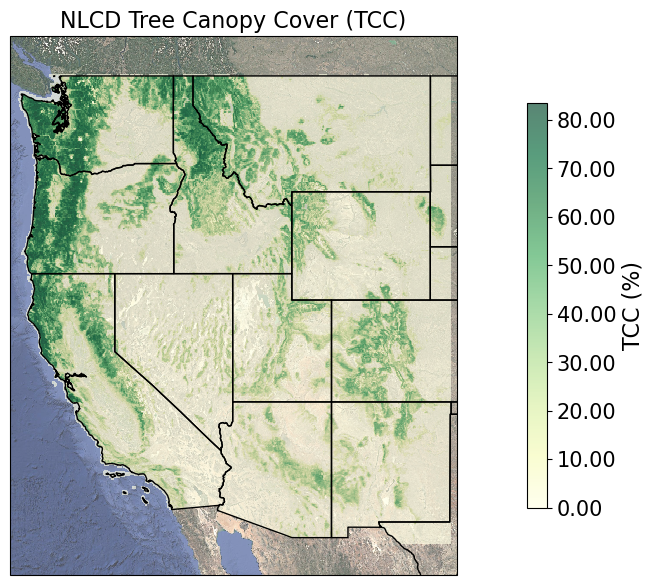

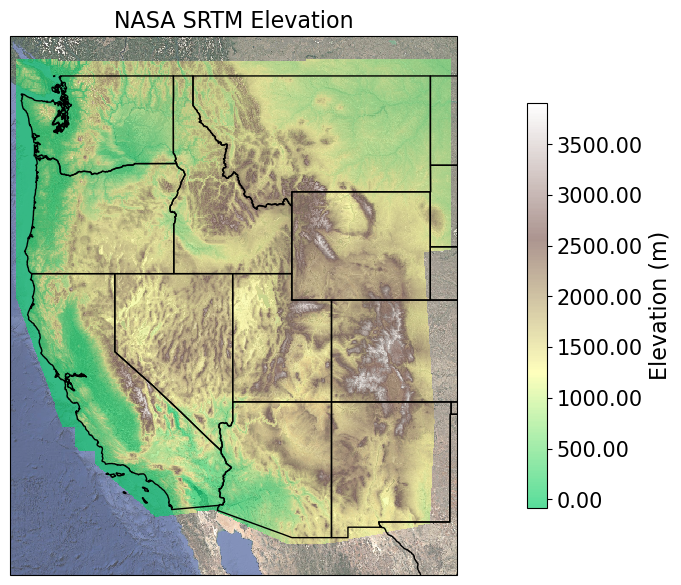

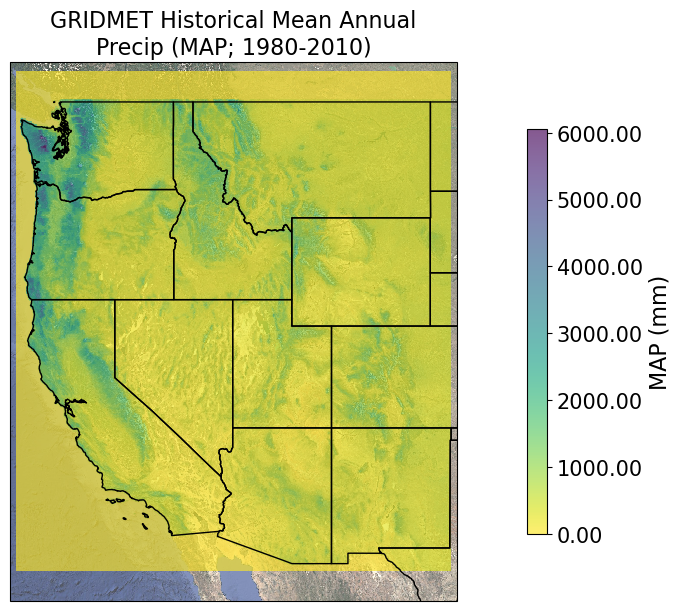

In [30]:

TCC_xr = xr.open_dataset(TCC_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['tree_canopy_cover'] # NLCD Tree Cover
elev_xr = xr.open_dataset(elev_file, decode_coords='all').rename({'lon':'x', 'lat':'y'}).sortby(['x', 'y'], ascending = True).squeeze('band')['elevation'] # SRTM Elevation
MAP_xr = xr.open_dataset(MAP_file, decode_coords='all').sortby(['x', 'y'], ascending = True)['mean'] # GRIDMET Mean Annual Precipitation

# Plot NLCD Tree Canopy Cover
plot_dataarray_map(TCC_xr, 'NLCD Tree Canopy Cover (TCC)', 
    'TCC (%)', cmap='YlGn')

# Plot NASA SRTM Elevation
# Custom terrain colormap for the elevation map - land only
terrain_colors = plt.cm.terrain(np.linspace(0.25, 1, 256))  # Skip the blue/water colors at the start
custom_terrain_cmap = mcolors.LinearSegmentedColormap.from_list('custom_terrain', terrain_colors)
plot_dataarray_map(elev_xr, 'NASA SRTM Elevation', 
    'Elevation (m)', cmap=custom_terrain_cmap)

# Plot GRIDMET Historical Mean Annual Precipitation
plot_dataarray_map(MAP_xr, 'GRIDMET Historical Mean Annual\nPrecip (MAP; 1980-2010)', 
    'MAP (mm)', cmap='viridis_r')



Now let's do a check for multi-collinearity in these predictors just to understand how correlated their patterns are:

In [ ]:


### Now let's include the geographic (static) variables - 
### first let's check for multicollinearity among them using VIF

# subset static variables for non-nan SIF
TCC_filt = TCC_xr.where(~np.isnan(TROPOMI_SIF_xr.isel(year=0)), drop=False)
elev_filt = elev_xr.where(~np.isnan(TROPOMI_SIF_xr.isel(year=0)), drop=False)
MAP_filt = MAP_xr.where(~np.isnan(TROPOMI_SIF_xr.isel(year=0)), drop=False)

# Create an array of the xarray variables to test as covariates
static_xr_arr = [TCC_filt, elev_filt, MAP_filt]
static_names = ['TCC', 'elevation', 'MAP']

# Stack the covariates into a 2D array (samples x features)
# First, flatten each covariate and combine into a DataFrame
static_data = []
for i, static_xr in enumerate(static_xr_arr):
    # Stack all dimensions and convert to a 1D array
    stacked = static_xr.stack(sample=static_xr.dims).values
    static_data.append(stacked)

# Create DataFrame with all covariates
static_df = pd.DataFrame(
    np.column_stack(static_data),
    columns=static_names
)

# Remove rows with any NaN values
static_df = static_df.dropna()

# Calculate VIF for each covariate
vif_geo_data = pd.DataFrame()
vif_geo_data["Variable"] = static_names
vif_geo_data["VIF"] = [variance_inflation_factor(static_df.values, i) 
                   for i in range(len(static_names))]

print(f"\nVariance Inflation Factors for geographic variables:")
print(vif_geo_data)

### Again, note that Variance inflation factors above 5-10 usually indicate multicollinearity
### These are all lower than 10 and are thus more manageable values




Variance Inflation Factors for geographic variables:
    Variable       VIF
0        TCC  8.429759
1  elevation  2.207673
2        MAP  6.315192


We can see above that there is a fair amount of multi-collinearity introduced into the static predictor set by the Tree Canopy Cover dataset (VIF = 8.4), and some more in the mean annual precipitation dataset (VIF = 6.3). These aren't aggregiously high, so we will proceed using these as candidates for predictors in the model together (for now)

### Nested data within Ecoregion groups

In the model above, we charactarized the relationship between annual SIF and its predictors for the entire Western US. We can estimate this for each individual ecoregion in addition to the greater Western US domain by nesting our data into groups using ecoregion as a categorical variable within our model. Let's take a look at the different EPA ecoregions of the Western US.

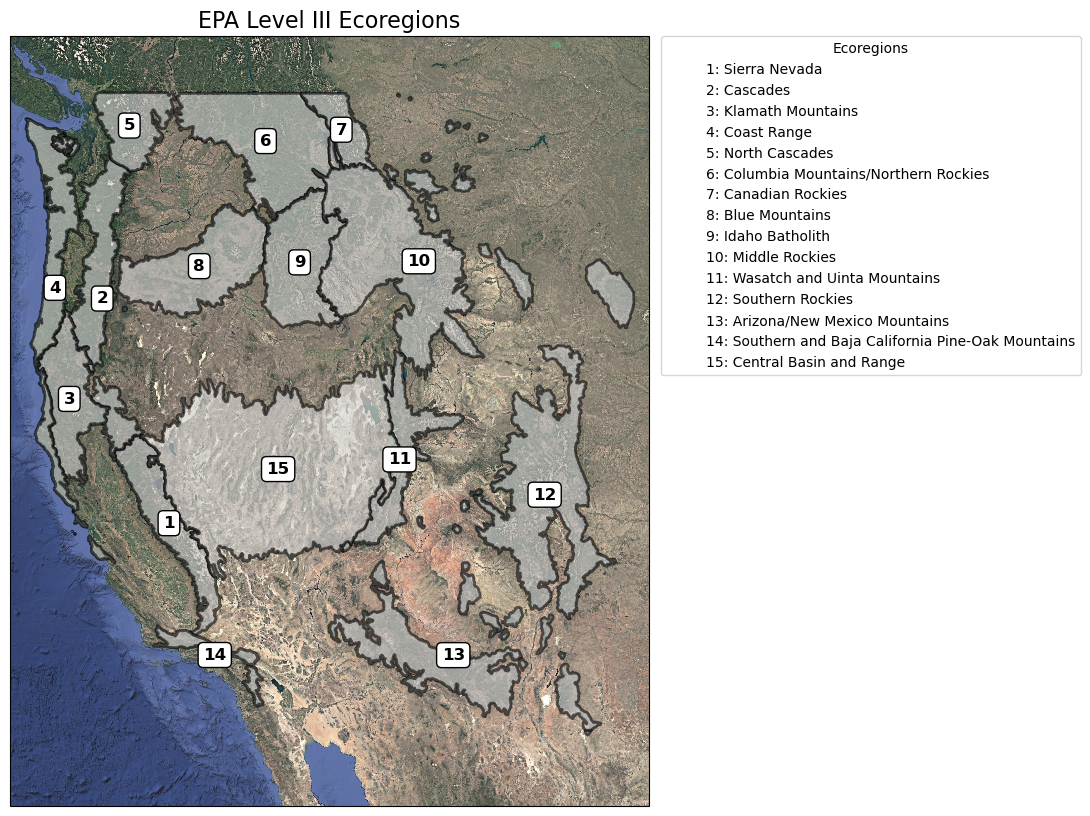

In [ ]:

# Load EPA L3 Ecoregion file and define individual region geometries
ecoregion_l3_gdf = gpd.read_file(EPA_ecoregion_L3_file)
Region1 = ['Sierra Nevada']
Region2 = ['Cascades']
Region3 = ['Klamath Mountains']
Region4 = ['Coast Range']
Region5 = ['North Cascades']
Region6 = ['Columbia Mountains/Northern Rockies']
Region7 = ['Canadian Rockies']
Region8 = ['Blue Mountains']
Region9 = ['Idaho Batholith'] 
Region10 = ['Middle Rockies']
Region11 = ['Wasatch and Uinta Mountains']
Region12 = ['Southern Rockies']
Region13 = ['Arizona/New Mexico Mountains']
Region14 = ['Southern and Baja California Pine-Oak Mountains']
Region15 = ['Central Basin and Range']

ecoregion_l3_gdf_Region1 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region1)]
ecoregion_l3_geom_Region1 = ecoregion_l3_gdf_Region1.geometry

ecoregion_l3_gdf_Region2 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region2)]
ecoregion_l3_geom_Region2 = ecoregion_l3_gdf_Region2.geometry

ecoregion_l3_gdf_Region3 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region3)]
ecoregion_l3_geom_Region3 = ecoregion_l3_gdf_Region3.geometry

ecoregion_l3_gdf_Region4 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region4)]
ecoregion_l3_geom_Region4 = ecoregion_l3_gdf_Region4.geometry

ecoregion_l3_gdf_Region5 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region5)]
ecoregion_l3_geom_Region5 = ecoregion_l3_gdf_Region5.geometry

ecoregion_l3_gdf_Region6 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region6)]
ecoregion_l3_geom_Region6 = ecoregion_l3_gdf_Region6.geometry

ecoregion_l3_gdf_Region7 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region7)]
ecoregion_l3_geom_Region7 = ecoregion_l3_gdf_Region7.geometry

ecoregion_l3_gdf_Region8 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region8)]
ecoregion_l3_geom_Region8 = ecoregion_l3_gdf_Region8.geometry

ecoregion_l3_gdf_Region9 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region9)]
ecoregion_l3_geom_Region9 = ecoregion_l3_gdf_Region9.geometry

ecoregion_l3_gdf_Region10 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region10)]
ecoregion_l3_geom_Region10 = ecoregion_l3_gdf_Region10.geometry

ecoregion_l3_gdf_Region11 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region11)]
ecoregion_l3_geom_Region11 = ecoregion_l3_gdf_Region11.geometry

ecoregion_l3_gdf_Region12 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region12)]
ecoregion_l3_geom_Region12 = ecoregion_l3_gdf_Region12.geometry

ecoregion_l3_gdf_Region13 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region13)]
ecoregion_l3_geom_Region13 = ecoregion_l3_gdf_Region13.geometry

ecoregion_l3_gdf_Region14 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region14)]
ecoregion_l3_geom_Region14 = ecoregion_l3_gdf_Region14.geometry

ecoregion_l3_gdf_Region15 = ecoregion_l3_gdf[ecoregion_l3_gdf.NA_L3NAME.isin(Region15)]
ecoregion_l3_geom_Region15 = ecoregion_l3_gdf_Region15.geometry

region_names = ['Sierra Nevada', 'Cascades', 'Klamath Mountains', 'Coast Range', 
                'North Cascades', 'Columbia Mountains/Northern Rockies', 'Canadian Rockies',
                'Blue Mountains', 'Idaho Batholith', 'Middle Rockies',
                'Wasatch and Uinta Mountains', 'Southern Rockies', 'Arizona/New Mexico Mountains', 
                'Southern and Baja California Pine-Oak Mountains', 'Central Basin and Range']

# List of region geometries and names
region_geoms = [
    ecoregion_l3_geom_Region1, ecoregion_l3_geom_Region2, ecoregion_l3_geom_Region3,
    ecoregion_l3_geom_Region4, ecoregion_l3_geom_Region5, ecoregion_l3_geom_Region6,
    ecoregion_l3_geom_Region7, ecoregion_l3_geom_Region8, ecoregion_l3_geom_Region9,
    ecoregion_l3_geom_Region10, ecoregion_l3_geom_Region11, ecoregion_l3_geom_Region12,
    ecoregion_l3_geom_Region13, ecoregion_l3_geom_Region14, ecoregion_l3_geom_Region15
]


# -------------------------------------------------------------------------
# function to assign ecoregion based on coordinates
# -------------------------------------------------------------------------
def assign_ecoregion(x, y):
    """
    Assign ecoregion number (1-15) based on point coordinates
    Returns None if point doesn't fall in any defined ecoregion
    """

    point = Point(x, y)
    
    # Dictionary mapping region lists to region numbers
    region_gdfs = {
        1: ecoregion_l3_gdf_Region1,
        2: ecoregion_l3_gdf_Region2,
        3: ecoregion_l3_gdf_Region3,
        4: ecoregion_l3_gdf_Region4,
        5: ecoregion_l3_gdf_Region5,
        6: ecoregion_l3_gdf_Region6,
        7: ecoregion_l3_gdf_Region7,
        8: ecoregion_l3_gdf_Region8,
        9: ecoregion_l3_gdf_Region9,
        10: ecoregion_l3_gdf_Region10,
        11: ecoregion_l3_gdf_Region11,
        12: ecoregion_l3_gdf_Region12,
        13: ecoregion_l3_gdf_Region13,
        14: ecoregion_l3_gdf_Region14,
        15: ecoregion_l3_gdf_Region15,
    }
    
    # Check which ecoregion contains the point
    for region_num, gdf in region_gdfs.items():
        if gdf.contains(point).any():
            return region_num
    
    return None


#### Plot a map of ecoregions
figsize = (12, 10)  # width, height in inches
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize=figsize)

# Set extent of map before adding base img
ax.set_extent(extent, crs=ccrs.PlateCarree())  # PlateCarree is default lat/lon
ax.add_image(tiler, tiler_zoom, interpolation='none', alpha=0.9) # Add base image

alpha = 0.65  # transparency 0-1

# Plot numbered text boxes at centroids of each region
import matplotlib.patches as mpatches


ax.add_geometries(ecoregion_l3_geom_Region1, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region2, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region3, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region4, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region5, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region6, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region7, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region8, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region9, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region10, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region11, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region12, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region13, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region14, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)
ax.add_geometries(ecoregion_l3_geom_Region15, crs=transform, facecolor="lightgray", edgecolor='black', linewidth=2, zorder=1, alpha = 0.6)

for i, geom_series in enumerate(region_geoms):
    # Use the union of parts to get a representative centroid for the region
    union_geom = geom_series.union_all()
    cent = union_geom.centroid
    ax.text(cent.x, cent.y, str(i + 1),
            transform=transform,
            fontsize=12, fontweight='bold',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3'),
            zorder=10)

# Build legend: number -> region name
labels = [f"{i+1}: {name}" for i, name in enumerate(region_names)]
proxies = [mpatches.Patch(facecolor=None, edgecolor=None, alpha=0) for _ in labels]
ax.legend(proxies, labels, loc='upper left', bbox_to_anchor=(1.02, 1.0),
          borderaxespad=0., fontsize=10, title='Ecoregions')
plt.xlabel('lon', fontsize=10)
plt.ylabel('lat', fontsize=10)
plt.title('EPA Level III Ecoregions') # set axis title
plt.show()

### Optimal model selection

Now we will introduce all the potential static predictor terms (also including latitude and a categorical term for ecoregions in here) into one model along with a relevant climate predictor - let's use Soil Moisture - and all interaction terms between the climate and static predictors. We will perform a stepwise model selection using AIC as the comparative metric, looking for the value with the lowest (in this case, the most negative) AIC. This will show us which model provides the most useful information for modeling SIF while trying to keep the model parsimonious.

### Fixed effects for every terms
For many ecological modeling applications it would make sense to model data like these with nested group structures, e.g. grouping the western US data  by ecoregion and assigning random effects to the slopes of each ecoregion. That is not what is shown in the example below - instead, we're modeling the ecoregion effects as fixed effects. This keeps the computational complexity of the problem at a manageable level

In [31]:
# Backward stepwise AIC selection for SIF ~ predictor + static variables + interactions
covar = 'SoilM'

# Prepare the dataset with static variables
print("\n" + "="*60)
print("Preparing data for stepwise AIC model selection")
print("="*60)

# Get covariate data (already clipped)
covar_xr = covariate_xr_arr[covariate_names.index(covar)]

# Create data dictionary including static variables
xr_data_dict = {
    'SIF': TROPOMI_SIF_xr,
    covar: covar_xr,
    'TCC': TCC_filt,
    'elevation': elev_filt,
    'MAP': MAP_filt
}

# Convert to long format dataframe
df_long = xarray_to_long_df(xr_data_dict, 'SIF')

# Add pixel_id and latitude
df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
df_long['latitude'] = df_long['y']

# Remove rows with missing values
df_model = df_long.dropna(subset=['SIF', covar, 'TCC', 'elevation', 'MAP', 'latitude']).copy()

# Apply to dataframe - this will take some time
print("Assigning ecoregions to pixels...")
df_model['ecoregion'] = df_model.apply(
    lambda row: assign_ecoregion(row['x'], row['y']), 
    axis=1
)

# Remove pixels not in any ecoregion
df_model = df_model.dropna(subset=['ecoregion']).copy()

# Convert to categorical for proper treatment in model
df_model['ecoregion'] = df_model['ecoregion'].astype('category')

# Standardize all predictors (including static variables)
all_predictors = [covar, 'TCC', 'elevation', 'MAP', 'latitude']
df_standardized = df_model.copy()
scaler = StandardScaler()
df_standardized[all_predictors] = scaler.fit_transform(df_model[all_predictors])

print("\n" + "="*60)
print("Starting backward stepwise AIC selection")
print("="*60)

# Define function to fit model and get AIC
def fit_model_get_aic(formula, data):
    """Fit mixed effects model and return AIC"""
    try:
        model = smf.mixedlm(formula, data=data, groups=data["pixel_id"])
        result = model.fit(method='powell')  # Use powell for better convergence
        llf = result.llf
        k = len(result.params) + 1  # +1 for variance component
        aic = -2 * llf + 2 * k
        return aic, result
    except Exception as e:
        print(f"  Model fitting failed: {e}")
        return np.inf, None


# Full model with all terms
full_terms = [covar, 'latitude', 'elevation', 'TCC', 'MAP', 'C(ecoregion)',
              f'latitude:{covar}', f'elevation:{covar}', f'TCC:{covar}', 
              f'MAP:{covar}', f'C(ecoregion):{covar}']
current_terms = full_terms.copy()

# Fit full model
full_formula = 'SIF ~ ' + ' + '.join(full_terms)
print(f"\nFull model: {full_formula}")
current_aic, current_result = fit_model_get_aic(full_formula, df_standardized)
print(f"AIC: {current_aic:.2f}")

# Store history of models tested
model_history = [(current_terms.copy(), current_aic)]

# Define hierarchical relationships: interaction term -> main effect
# Use the actual covar variable value
interaction_map = {
    f'latitude:{covar}': 'latitude',
    f'elevation:{covar}': 'elevation',
    f'TCC:{covar}': 'TCC',
    f'MAP:{covar}': 'MAP'
}

print(f"\nInteraction map: {interaction_map}")
print(f"Current terms: {current_terms}")

# Helper function to get terms that must be removed together
def get_removal_group(term, current_terms):
    """
    Get the group of terms that must be removed together.
    If removing a main effect, also remove ALL its interaction terms.
    Interaction terms can only be removed with their main effect.
    """
    # Check if term is a main effect that appears in interaction_map values
    if term in interaction_map.values():
        # Find ALL interactions involving this main effect that are currently in the model
        interactions = [k for k, v in interaction_map.items() if v == term and k in current_terms]
        
        if interactions:
            print(f"  Note: '{term}' has interactions {interactions} that will be removed together")
            return [term] + interactions
        else:
            # Main effect has no interactions in current model
            return [term]
    
    # Check if term is in interaction_map keys (it's a tracked interaction)
    elif term in interaction_map.keys():
        # This interaction involves tracked main effects - can't remove alone
        return None
    
    # Check if term contains ':' and might be an interaction
    elif ':' in term:
        # This is some other interaction (e.g., categorical interactions)
        # Parse to see if it involves any of our tracked main effects
        parts = term.split(':')
        # Remove 'C()' wrapper if present
        clean_parts = [p.replace('C(', '').replace(')', '') for p in parts]
        
        # Check if any part is a tracked main effect
        main_effects_involved = [p for p in clean_parts if p in interaction_map.values()]
        
        if main_effects_involved:
            # Can't remove this interaction without removing main effect
            return None
        else:
            # This is a categorical interaction or other - allow removal
            return [term]
    
    else:
        # For other terms (like the main covariate or standalone variables), allow removal
        return [term]

# Backward stepwise elimination
iteration = 1
improvement_found = True

# Note: Always keep the covariate in the model as it's the main predictor
terms_to_test = [t for t in current_terms if t != covar]

while improvement_found and len(terms_to_test) > 0:
    print(f"\n{'-'*60}")
    print(f"Iteration {iteration}")
    print(f"{'-'*60}")
    
    improvement_found = False
    best_aic = current_aic
    best_terms_to_remove = None
    best_result = current_result
    
    # Try removing each term (except the main covariate which we always keep)
    for term in terms_to_test:
        # Get all terms that need to be removed together
        removal_group = get_removal_group(term, current_terms)
        
        # Skip if this term cannot be removed independently
        if removal_group is None:
            print(f"Skipping '{term}' (interaction term - can only be removed with main effect)")
            continue
        
        # Skip if removal_group is empty
        if len(removal_group) == 0:
            continue
        
        # Create test model without these terms
        test_terms = [t for t in current_terms if t not in removal_group]
        test_formula = 'SIF ~ ' + ' + '.join(test_terms)
        
        if len(removal_group) > 1:
            print(f"Testing removal of '{term}' + {removal_group[1:]}...")
        else:
            print(f"Testing removal of '{term}'...")
        
        test_aic, test_result = fit_model_get_aic(test_formula, df_standardized)
        print(f"  AIC: {test_aic:.2f}")
        
        # Check if removing this term improves (lowers) AIC
        if test_aic < best_aic:
            best_aic = test_aic
            best_terms_to_remove = removal_group
            best_result = test_result
            improvement_found = True
    
    # If we found an improvement, update the current model
    if improvement_found:
        for term in best_terms_to_remove:
            if term not in current_terms:
                print(f"WARNING: Trying to remove '{term}' but it's not in current_terms!")
                print(f"Current terms: {current_terms}")
            current_terms.remove(term)
        
        current_aic = best_aic
        current_result = best_result
        terms_to_test = [t for t in current_terms if t != covar]
        
        if len(best_terms_to_remove) > 1:
            print(f"\n✓ Removed {best_terms_to_remove} - New AIC: {current_aic:.2f}")
        else:
            print(f"\n✓ Removed '{best_terms_to_remove[0]}' - New AIC: {current_aic:.2f}")
        print(f"  Remaining terms: {current_terms}")
        model_history.append((current_terms.copy(), current_aic))
    else:
        print(f"\nNo improvement found. Stopping.")
    
    iteration += 1

# Print final results
print("\n" + "="*60)
print("STEPWISE SELECTION COMPLETE")
print("="*60)

print("\n" + "-"*60)
print("Model Selection History:")
print("-"*60)
for i, (terms, aic) in enumerate(model_history):
    print(f"Step {i}: AIC = {aic:.2f}")
    print(f"  Terms: {' + '.join(terms)}")

print("\n" + "-"*60)
print("BEST MODEL (Lowest AIC):")
print("-"*60)
best_model_idx = np.argmin([aic for _, aic in model_history])
best_terms, best_aic = model_history[best_model_idx]
best_formula = 'SIF ~ ' + ' + '.join(best_terms)

print(f"Formula: {best_formula}")
print(f"AIC: {best_aic:.2f}")

# Refit the best model to get full summary
print("\n" + "-"*60)
print("Fitting final model...")
print("-"*60)
final_model = smf.mixedlm(best_formula, data=df_standardized, groups=df_standardized["pixel_id"])
final_result = final_model.fit(method='powell')

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(final_result.summary())

# Calculate R² for final model
r2_marginal, r2_conditional = calculate_mixed_model_r2(final_result, df_standardized)
print(f"\nMarginal R²: {r2_marginal:.4f}")
print(f"Conditional R²: {r2_conditional:.4f}")

# Save results
stepwise_results = {
    'best_formula': best_formula,
    'best_terms': best_terms,
    'best_aic': best_aic,
    'final_result': final_result,
    'model_history': model_history,
    'r2_marginal': r2_marginal,
    'r2_conditional': r2_conditional
}


Preparing data for stepwise AIC model selection
Assigning ecoregions to pixels...

Starting backward stepwise AIC selection

Full model: SIF ~ SoilM + latitude + elevation + TCC + MAP + C(ecoregion) + latitude:SoilM + elevation:SoilM + TCC:SoilM + MAP:SoilM + C(ecoregion):SoilM


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


AIC: -76137.89

Interaction map: {'latitude:SoilM': 'latitude', 'elevation:SoilM': 'elevation', 'TCC:SoilM': 'TCC', 'MAP:SoilM': 'MAP'}
Current terms: ['SoilM', 'latitude', 'elevation', 'TCC', 'MAP', 'C(ecoregion)', 'latitude:SoilM', 'elevation:SoilM', 'TCC:SoilM', 'MAP:SoilM', 'C(ecoregion):SoilM']

------------------------------------------------------------
Iteration 1
------------------------------------------------------------
  Note: 'latitude' has interactions ['latitude:SoilM'] that will be removed together
Testing removal of 'latitude' + ['latitude:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -76142.13
  Note: 'elevation' has interactions ['elevation:SoilM'] that will be removed together
Testing removal of 'elevation' + ['elevation:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -72832.22
  Note: 'TCC' has interactions ['TCC:SoilM'] that will be removed together
Testing removal of 'TCC' + ['TCC:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -73814.69
  Note: 'MAP' has interactions ['MAP:SoilM'] that will be removed together
Testing removal of 'MAP' + ['MAP:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -75777.19
Testing removal of 'C(ecoregion)'...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -73376.63
Skipping 'latitude:SoilM' (interaction term - can only be removed with main effect)
Skipping 'elevation:SoilM' (interaction term - can only be removed with main effect)
Skipping 'TCC:SoilM' (interaction term - can only be removed with main effect)
Skipping 'MAP:SoilM' (interaction term - can only be removed with main effect)
Testing removal of 'C(ecoregion):SoilM'...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -74442.24

✓ Removed ['latitude', 'latitude:SoilM'] - New AIC: -76142.13
  Remaining terms: ['SoilM', 'elevation', 'TCC', 'MAP', 'C(ecoregion)', 'elevation:SoilM', 'TCC:SoilM', 'MAP:SoilM', 'C(ecoregion):SoilM']

------------------------------------------------------------
Iteration 2
------------------------------------------------------------
  Note: 'elevation' has interactions ['elevation:SoilM'] that will be removed together
Testing removal of 'elevation' + ['elevation:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -72523.73
  Note: 'TCC' has interactions ['TCC:SoilM'] that will be removed together
Testing removal of 'TCC' + ['TCC:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -73724.95
  Note: 'MAP' has interactions ['MAP:SoilM'] that will be removed together
Testing removal of 'MAP' + ['MAP:SoilM']...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -75717.79
Testing removal of 'C(ecoregion)'...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -72809.14
Skipping 'elevation:SoilM' (interaction term - can only be removed with main effect)
Skipping 'TCC:SoilM' (interaction term - can only be removed with main effect)
Skipping 'MAP:SoilM' (interaction term - can only be removed with main effect)
Testing removal of 'C(ecoregion):SoilM'...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


  AIC: -74383.56

No improvement found. Stopping.

STEPWISE SELECTION COMPLETE

------------------------------------------------------------
Model Selection History:
------------------------------------------------------------
Step 0: AIC = -76137.89
  Terms: SoilM + latitude + elevation + TCC + MAP + C(ecoregion) + latitude:SoilM + elevation:SoilM + TCC:SoilM + MAP:SoilM + C(ecoregion):SoilM
Step 1: AIC = -76142.13
  Terms: SoilM + elevation + TCC + MAP + C(ecoregion) + elevation:SoilM + TCC:SoilM + MAP:SoilM + C(ecoregion):SoilM

------------------------------------------------------------
BEST MODEL (Lowest AIC):
------------------------------------------------------------
Formula: SIF ~ SoilM + elevation + TCC + MAP + C(ecoregion) + elevation:SoilM + TCC:SoilM + MAP:SoilM + C(ecoregion):SoilM
AIC: -76142.13

------------------------------------------------------------
Fitting final model...
------------------------------------------------------------


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



FINAL MODEL SUMMARY
                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     SIF       
No. Observations:       20794       Method:                 REML      
No. Groups:             20794       Scale:                  0.0001    
Min. group size:        1           Log-Likelihood:         38109.0654
Max. group size:        1           Converged:              Yes       
Mean group size:        1.0                                           
----------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   0.191    0.002 112.178 0.000  0.187  0.194
C(ecoregion)[T.2.0]        -0.038    0.002 -16.202 0.000 -0.042 -0.033
C(ecoregion)[T.3.0]        -0.030    0.004  -6.603 0.000 -0.038 -0.021
C(ecoregion)[T.4.0]         0.007    0.004   2.057 0.040  0.000  0.014
C(

Looks like the only variables that were optimal to exclude were latitude and the interaction term between latitude and soil moisture. Thus, the selected model after this stepwise selection is the one that includes the climate predictor, Tree canopy cover, elevation, mean annual precipitation, ecoregion categories and the interactions of these variables with Tree canopy cover. 

### Running the model with all climate predictors

We will run separate models for each climate predictor. Each model will include all the relevant geographic charactaristics that we identified in the step above.


Modeling variable: Tmax
Assigning ecoregions to pixels...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: Tmin
Assigning ecoregions to pixels...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: VPD
Assigning ecoregions to pixels...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: Precip
Assigning ecoregions to pixels...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Modeling variable: SoilM
Assigning ecoregions to pixels...


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


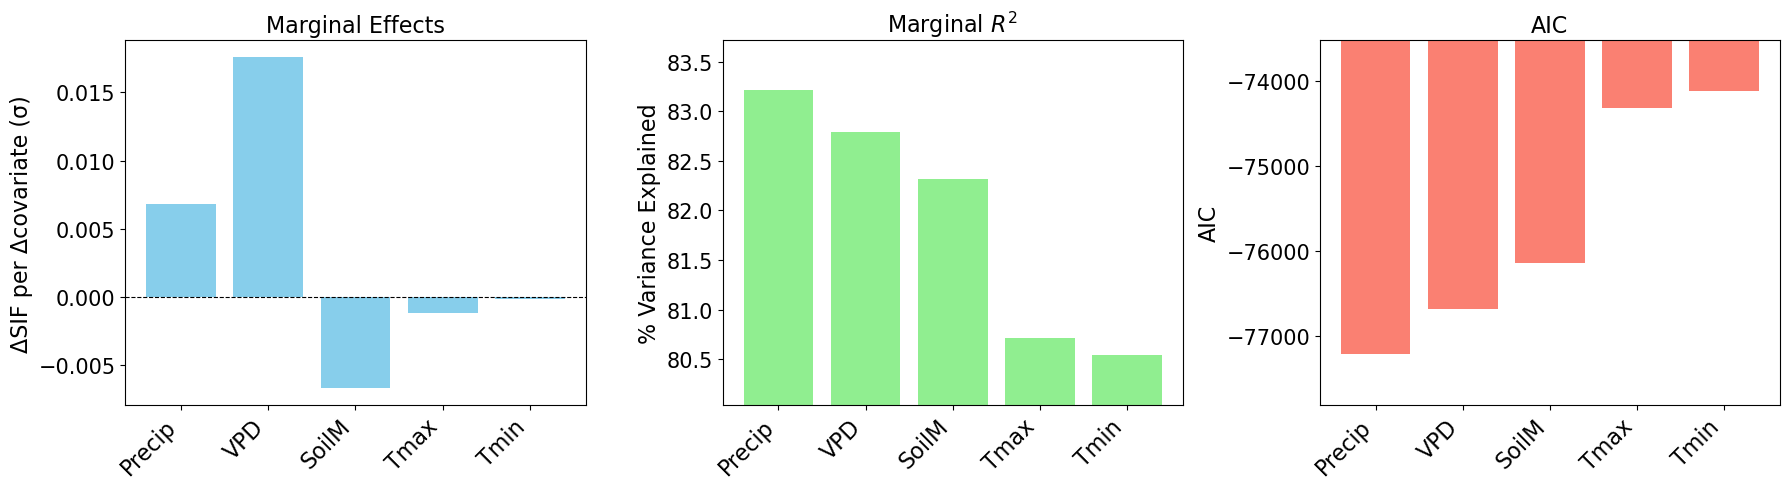

In [32]:

covariate_results = {}

for covariate_xr, covariate_name in zip(covariate_xr_arr, covariate_names):

    print(f"\nModeling variable: {covariate_name}")
    model_results = {}
    xr_data_dict = {
        'SIF': TROPOMI_SIF_xr,
        covariate_name: covariate_xr,
        'TCC': TCC_filt,
        'elevation': elev_filt,
        'MAP': MAP_filt
    }

    df_long = xarray_to_long_df(xr_data_dict, 'SIF')
    key_vars = ['SIF', covariate_name]

    # Add pixel_id, longitude, latitude
    df_long['pixel_id'] = df_long['x'].astype(str) + '_' + df_long['y'].astype(str)
    df_long['longitude'] = df_long['x']
    df_long['latitude'] = df_long['y']

    # Clean up - remove rows with missing values in key variables
    df_model = df_long.dropna(subset=key_vars).copy()

    # Apply to dataframe - this will take some time
    print("Assigning ecoregions to pixels...")
    df_model['ecoregion'] = df_model.apply(
        lambda row: assign_ecoregion(row['x'], row['y']), 
        axis=1
    )

    # Remove pixels not in any ecoregion
    df_model = df_model.dropna(subset=['ecoregion']).copy()

    # Convert to categorical for proper treatment in model
    df_model['ecoregion'] = df_model['ecoregion'].astype('category')

    # Standardize predictors
    all_predictors = [covariate_name] + static_names
    df_standardized = df_model.copy()
    df_standardized[all_predictors] = StandardScaler().fit_transform(df_model[all_predictors])

    # Fit mixed effects model (random intercepts per pixel)
    formula = f'SIF ~ {covariate_name} + TCC + elevation + MAP + C(ecoregion) + elevation:{covariate_name} + TCC:{covariate_name} + MAP:{covariate_name} + C(ecoregion):{covariate_name}'
    try:
        model = smf.mixedlm(
            formula, data=df_standardized,
            groups=df_standardized["pixel_id"]
        )
        result = model.fit()
        model_results['full_result'] = result
        model_results['coeff'] = result.params[covariate_name]
    except Exception as e:
        print(f"Model fitting failed: {e}")

    # Calculate marginal and conditional R²
    r2_marginal, r2_conditional = calculate_mixed_model_r2(result, df_standardized)
    model_results['r2_marginal'] = r2_marginal
    model_results['r2_conditional'] = r2_conditional

    #### compute AIC and fit metrics
    # Get log-likelihood and number of parameters
    llf = result.llf  # log-likelihood
    nobs = result.nobs  # number of observations
    k = len(result.params) + 1  # +1 for variance component

    # Calculate AIC and BIC manually
    aic = -2 * llf + 2 * k
    bic = -2 * llf + k * np.log(nobs)
    model_results['AIC'] = aic
    model_results['BIC'] = bic

    # # Below is Dave's method
    # # predicted_values = result.predict(df_standardized)
    # predicted_values = result.fittedvalues
    # # Get fitted parameters and covariance matrix from the model result
    # popt = result.params.values
    # pcov = result.cov_params().values
    # n_params = len(popt) + 1 # +1 for variance component

    # fit_metrics = calc_fit_metrics(df_standardized['SIF'], predicted_values, popt=popt, pcov=pcov, n_params=n_params)

    covariate_results[covariate_name] = model_results

# Print the 'r2_marginal' for each covariate_name, sorted from highest to lowest
sorted_r2_marginal = sorted(
    ((name, res['r2_marginal']) for name, res in covariate_results.items()),
    key=lambda x: x[1], reverse=True
)

# Get the covariate order from sorted_r2_marginal
covariate_order = [name for name, _ in sorted_r2_marginal]

# Get values in this order
coeffs = [covariate_results[name]['coeff'] for name in covariate_order]
r2s = [covariate_results[name]['r2_marginal']*100 for name in covariate_order]
aics = [covariate_results[name]['AIC'] for name in covariate_order]

# Marginal R^2 percentage limits
r2_min = min(r2s) - 0.5
r2_max = max(r2s) + 0.5

# AIC limits
aic_min = min(aics) - 100
aic_max = max(aics) + 100

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

# Coefficient bar plot
axes[0].bar(covariate_order, coeffs, color='skyblue')
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].set_title('Marginal Effects')
axes[0].set_ylabel('ΔSIF per Δcovariate (σ)')
axes[0].set_xticks(range(len(covariate_order)))
axes[0].set_xticklabels(covariate_order, rotation=45, ha='right')

# Marginal R^2 bar plot
axes[1].bar(covariate_order, r2s, color='lightgreen')
axes[1].set_title('Marginal $R^2$')
axes[1].set_ylabel('% Variance Explained')
axes[1].set_ylim(r2_min, r2_max)
axes[1].set_xticks(range(len(covariate_order)))
axes[1].set_xticklabels(covariate_order, rotation=45, ha='right')

# AIC bar plot
axes[2].bar(covariate_order, aics, color='salmon')
axes[2].set_title('AIC')
axes[2].set_ylabel('AIC')
axes[2].set_ylim(aic_min-500, aic_max+500)
axes[2].set_xticks(range(len(covariate_order)))
axes[2].set_xticklabels(covariate_order, rotation=45, ha='right')

plt.tight_layout()
plt.show()



After including the geographic predictor terms, the marginal effects, marginal $R^{2}$ and AIC have changed differently for the different predictors. Now, VPD has the strongest marginal effect on SIF but Precipitation accounts for the most variability in annual SIF when including elevation, MAP, and tree canopy cover effects and their interactions. 

### Residual autocorrelation

We didn't explicitly account for spatial autocorrelation in the model but let's test the model residuals for this to see if it is still present

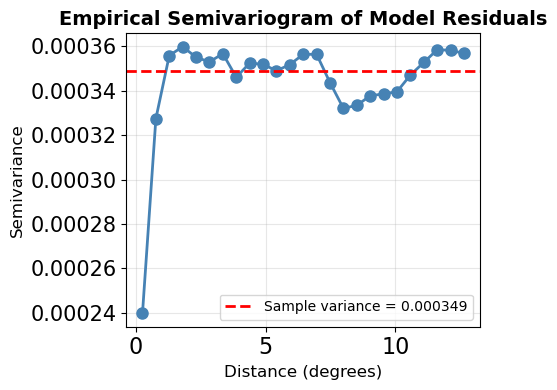

In [33]:

### Let's check for spatial correlation in the residuals of the Precipitation model

# Get residuals from the model
residuals = covariate_results['Precip']['full_result'].resid

# Create DataFrame with residuals and spatial info
resid_df = df_standardized[['pixel_id', 'x', 'y', 'year']].copy()
resid_df['residual'] = residuals.values

# Get pixel-level mean residuals (averaged across years)
pixel_resid = resid_df.groupby('pixel_id').agg({
    'x': 'first',
    'y': 'first', 
    'residual': 'mean'
}).reset_index()

# Extract coordinates
coords = pixel_resid[['x', 'y']].values

# Calculate Euclidean distances (in degrees)
# For more accurate distances, you could convert to meters using geopy
distances = pdist(coords, metric='euclidean')

# Convert to square matrix for easier indexing
distance_matrix = squareform(distances)

# Calculate empirical variogram
# Limit to reasonable max distance (e.g., half the max distance)
max_dist = distance_matrix.max() / 2

bin_centers, semivariance, pair_counts = calculate_semivariogram(
    pixel_resid['residual'].values,
    distances,
    n_bins=25,
    max_distance=max_dist
)

# Filter out bins with too few pairs
min_pairs = 30
valid_bins = pair_counts >= min_pairs

#########################################
# Plot empirical variogram
#########################################
fig, ax = plt.subplots(figsize=(5, 4))

# Plot 1: Semivariogram
ax.plot(bin_centers[valid_bins], semivariance[valid_bins], 
         'o-', markersize=8, linewidth=2, color='steelblue')
ax.axhline(y=pixel_resid['residual'].var(), 
            color='red', linestyle='--', linewidth=2,
            label=f'Sample variance = {pixel_resid["residual"].var():.6f}')
ax.set_xlabel('Distance (degrees)', fontsize=12)
ax.set_ylabel('Semivariance', fontsize=12)
ax.set_title('Empirical Semivariogram of Model Residuals', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()


This empirical semivariogram shows a distinct pattern indicating spatial autocorrelation between residuals in pixels that are less than ~1 deg lon/lat euclidian distance from one another. So there is some spatial autocorrelation structure that is unaccounted for in our model framework. Is this a big deal? How would we go about dealing with this? I'm still unsure...